# Final Project Submission

Please fill out:
* Student name: **Darius Fuller**
* Student pace: self paced / **part time** / full time
* Scheduled project review date/time: **TBD**
* Instructor name: **James Irving**
* Blog post URL: **https://medium.com/@d_full22/getting-sentimental-2db354e833bc**

# The Problem

> In this project I will be building a NLP model to analyze Twitter sentiment about various Apple and Google products. The end result will be able to look at a tweet and predict whether its underlying sentiment is *negative*, *neutral*, or *positive*.

> The dataset used can be found at this data.world page: [Click here](https://data.world/crowdflower/brands-and-product-emotions)

## The plan

> Although NLP can be achieved with more traditional machine learning models, I want to give this a try using a *Recurrent Neural Network* (RNN) which would be considered a Deep Learning model. I will be doing so through the Tensorflow/Keras packaging.

# Imports

In [1]:
import pandas as pd
import numpy as np
import functions as dlf
import matplotlib.pyplot as plt
import warnings
import string
np.random.seed(22)
warnings.filterwarnings('ignore')

In [49]:
from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk import word_tokenize, TweetTokenizer
from gensim.models import word2vec
from imblearn.over_sampling import SMOTE
# from kerastuner.tuners import RandomSearch
# from kerastuner.engine.hyperparameters import HyperParameters
# from tensorflow.keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from nltk.corpus import stopwords

> Originally, when attempting to tune my models, I explored the `kerastuner` API. However, due to time limitations and version compatibility issues, I was unable to implement it successfully. This is one of the things I will come back to later if an opportunity to re-work this problem arises.

# Data Prep

## Loading + Null Values

In [3]:
## Loading in raw data + quick check
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


> This dataset was *really* easy to plug-and-play with. In addition, one benefit to using ANNs for NLP is that it can learn from the sequence of words in order, meaning that the amount of preprocessing can be minimal prior to modeling begins. 

In [4]:
## Broad-scoped check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


> There are just under 2/3 of the data missing for the `emotion_in_tweet_is_directed_at` column. I will not include this for my sentiment analysis but I do think that it could be useful for me later in terms of guessing what product the tweet is talking about.
* Otherwise I only need to address the **one** null value in `tweet_text`.

In [5]:
## Verifying location of null value
df.loc[df['tweet_text'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


In [6]:
## NA removal + sanity check + version control
df_prep = df.drop(index=6, columns='emotion_in_tweet_is_directed_at').copy()
print('Total # of null values by column:')
display(df_prep.isna().sum())

Total # of null values by column:


tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

> With all of the null values being removed, the next step will be the train-test split and creation of my target variable.

## Train-Test Split

In [7]:
## Creating the variables
X = df_prep['tweet_text'].copy()
y = df_prep['is_there_an_emotion_directed_at_a_brand_or_product'].copy()

> Models require text data to be put into a numerical representation to allow for learning. I need to create a `target` variable for my model to evaluate its performance upon.

In [8]:
## Setting dictionary for which y-values will be mapped to
values = {'No emotion toward brand or product': 1, 'Positive emotion': 2,
          'Negative emotion': 0, "I can't tell": 1}
y = y.map(values)

print('Counts by class:')
y.value_counts()

Counts by class:


1    5544
2    2978
0     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [9]:
## Converting pandas series into one-hot encoded 2D array
y_ohe = to_categorical(y)

print("OHE'd target values:")
display(y_ohe)

OHE'd target values:


array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [11]:
## 70/30 Train-test split w/stratify to help with class imbalance + q.c.
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.3,
                                                    stratify=y, random_state=333)

print('First item in training data:')
X_train[X_train.first_valid_index()]

First item in training data:


'Forgot my iPhone for #sxsw. Android only. Knife to a gun fight'

## Tokenize + Sequence + SMOTE

> In order to comply with Keras' requirements, I need to re-process the text with their `Tokenizer` class followed by a conversion to a padded sequence.


In [12]:
## Tokenize + convert to padded sequences
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(X_train)

X_tr_seq = tokenizer.texts_to_sequences(X_train)
X_tr_seq = sequence.pad_sequences(X_tr_seq, maxlen=100)

X_te_seq = tokenizer.texts_to_sequences(X_test)
X_te_seq = sequence.pad_sequences(X_te_seq, maxlen=100)

In [13]:
## Quick check
print('First index item in its sequenced (truncated) and text-form:\n')
display((X_tr_seq[0, 80:100]), (tokenizer.sequences_to_texts([X_tr_seq[0]])))

First index item in its sequenced (truncated) and text-form:



array([   0,    0,    0,    0,    0,    0,    0,    0, 1219,   29,   18,
          8,    1,   40,  112, 3119,    5,   11, 1120,  677])

['forgot my iphone for sxsw android only knife to a gun fight']

In [23]:
## Q.c of class distribution
print('Class distribution in training data:')
pd.Series(y_train.argmax(axis=1)).value_counts(normalize=True)

Class distribution in training data:


1    0.609837
2    0.327467
0    0.062696
dtype: float64

> I will applying imblearn's SMOTE synthetic oversampler to address my class imbalance.

> I came to this decision after training some models with the distribution *as-is*. This lead to the models over-fitting quickly to predict class 1 (Neutral emotion). This allowed them to achieve higher scores by only predicting this class. There are many options to go with in regards to oversampling, but I went with SMOTE due to its synthetic nature. This (in theory) will help prevent overfitting due to repetition of the same values that would otherwise be made with other methods.

In [24]:
## Applying SMOTE to address class imbalance
smt = SMOTE(random_state=333)
X_tr_seq_smt, y_tr_smt = smt.fit_sample(X_tr_seq, y_train)

In [26]:
## Q.c of class distribution
print('Class distribution in training data (after balancing):')
pd.Series(y_tr_smt.argmax(axis=1)).value_counts(normalize=True)

Class distribution in training data (after balancing):


2    0.333333
1    0.333333
0    0.333333
dtype: float64

# Building a 'baseline'

## Instantiation

> Now I will build a baseline model to use a reference point for any tweaks I make during the tuning process. This model will include an embedding layer and two hidden layers; one LSTM and one Dense. The output layer will be Dense as well, with the required softmax activation function since we have more than two classes as possible predictions.

In [27]:
## Instantiate model + select embedding size
model = Sequential()
embedding_size = 128

> I am choosing an embedding size of 128 as it is a common convention for ANNs performing this kind of task.

## Compilation

> Reasoning for model:
* `LSTM` layer is added to help retain the information intelligently gained from the ordered sequences
* `GlobalMaxPool1D` is necessary to transform a matrix into a 1-Dimensional representation that is compatible with the following Dense layer
* `Dropout` is added as a regularization measure to aid in generalization of what is learned by the model
* `'relu'` activation function is used to help mitigate exploding/vanishing gradient problem
* `'adam'` optimizer due to its adaptive capabilities with respect to the learning rate
* `'accuracy'` as the metric since I will be looking to correctly identify the sentiment correctly across all classes

In [28]:
## To be added as 'input_dim' for input layer
num_words = X_tr_seq.max() + 1
num_words

## Input layer (input) + dimensions for learning
model.add(Embedding(num_words, embedding_size))

## 1st hidden layer + Pooling to 1d representation + dropout regularization
model.add(LSTM(20, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.3))

## 2nd hidden layer + dropout reg.
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.3))

## Output layer 
model.add(Dense(3, activation='softmax'))

## Compliling model to use Adam / accuracy metric
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

## Q.C
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1104896   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          11920     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

## Training

In [29]:
## Instantiate custom timer class to track training times
t1 = dlf.Timer()

> I am going to add a validation split of 30% of the training data for the model to evaluate each epochs predictions upon before back-propagation. This will hopefully reduce over-fitting as well.

In [30]:
## Training!
t1.start()
history1 = model.fit(X_tr_seq_smt, y_tr_smt, batch_size=64, epochs=25, validation_split=0.3, verbose=2)
print('\n')
t1.stop()

Train on 8150 samples, validate on 3493 samples
Epoch 1/25
 - 26s - loss: 1.0513 - accuracy: 0.4724 - val_loss: 1.2949 - val_accuracy: 0.0000e+00
Epoch 2/25
 - 18s - loss: 0.9331 - accuracy: 0.5266 - val_loss: 1.2893 - val_accuracy: 0.2814
Epoch 3/25
 - 18s - loss: 0.7369 - accuracy: 0.6897 - val_loss: 1.5996 - val_accuracy: 0.4194
Epoch 4/25
 - 25s - loss: 0.5710 - accuracy: 0.7697 - val_loss: 1.9918 - val_accuracy: 0.4054
Epoch 5/25
 - 26s - loss: 0.4743 - accuracy: 0.8160 - val_loss: 2.3661 - val_accuracy: 0.4526
Epoch 6/25
 - 26s - loss: 0.3934 - accuracy: 0.8518 - val_loss: 2.7185 - val_accuracy: 0.4549
Epoch 7/25
 - 28s - loss: 0.3354 - accuracy: 0.8782 - val_loss: 2.8420 - val_accuracy: 0.4541
Epoch 8/25
 - 21s - loss: 0.3058 - accuracy: 0.8875 - val_loss: 3.2539 - val_accuracy: 0.4475
Epoch 9/25
 - 20s - loss: 0.2913 - accuracy: 0.9006 - val_loss: 3.4715 - val_accuracy: 0.4469
Epoch 10/25
 - 26s - loss: 0.2624 - accuracy: 0.9063 - val_loss: 3.6976 - val_accuracy: 0.4646
Epoch 1

## Evaluation

> I am going to put the training results into a visualization so that I can get a gauge on how well the training process itself is going.

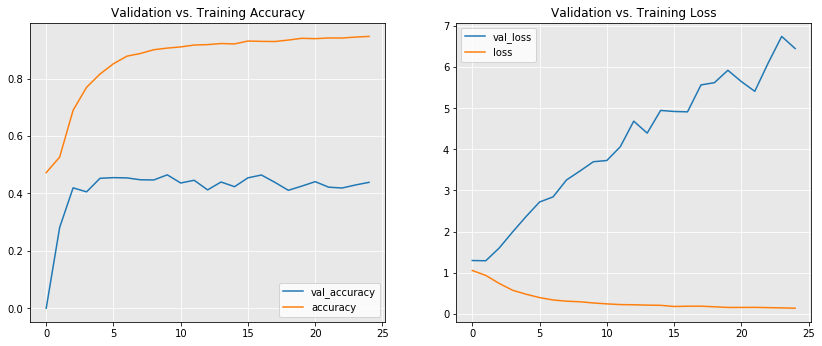

In [31]:
## Figure, axes to plot results
fig, ax = plt.subplots(ncols=2, figsize=(14,5.5))

## Converting metrics in history object to Df for ease of plotting
res_df1 = pd.DataFrame(history1.history)

## Accuracy plot
res_df1[['val_accuracy', 'accuracy']].plot(title='Validation vs. Training Accuracy', ax=ax[0])
ax[0].grid(color='w')
ax[0].set_facecolor('#e8e8e8')

## Loss plot + reveal
res_df1[['val_loss', 'loss']].plot(title='Validation vs. Training Loss', ax=ax[1])
ax[1].grid(color='w')
ax[1].set_facecolor('#e8e8e8')
plt.show();

> Since this is ultimately a classification problem, I will make use of the `classification_report` and `confusion_matrix` functions from Sklearn's metrics module to display and visualize my model's perfomance.

Classification Report:

              precision    recall  f1-score   support

           0       0.22      0.36      0.27       171
           1       0.74      0.68      0.71      1663
           2       0.54      0.56      0.55       894

    accuracy                           0.62      2728
   macro avg       0.50      0.53      0.51      2728
weighted avg       0.64      0.62      0.63      2728



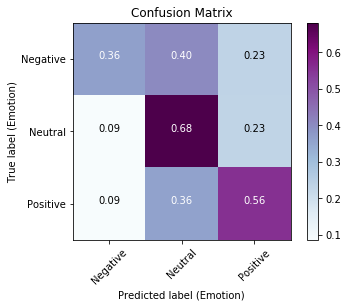

In [32]:
## Create predictions to use with sklearn classif. report
y_hat_te = model.predict(X_te_seq)

## Coercing ohe + probabilities into class predictions 
y_test_cls = y_test.argmax(axis=1)
y_hat_te_cls = y_hat_te.argmax(axis=1)

## Results!
print('Classification Report:\n')
print(metrics.classification_report(y_test_cls, y_hat_te_cls))

## Creating raw normalized conf. matrix
cm = metrics.confusion_matrix(y_test_cls, y_hat_te_cls, normalize='true')

## Setting labels for custom function + display
labels = ['Negative', 'Neutral', 'Positive']
dlf.plot_confusion_matrix(cm, labels)

> **62% accuracy** is a good start! The plots definitely show evidence of *overfitting*, as the validation accuracy is much lower (and fluctuating) while the training accuracy and validation loss continue to increase.

> In an effort to help the model address this issue, I will see if using pre-trained word embeddings in addition to tweaking the baseline model itself to attempt to increase overall accuracy.

# Transfer Learning

## Word2Vec

### Tokenizing

> NLTK offers two different tokenizers I felt could be compared with regards to my model's performance. The first being a generalized function, `word_tokenize()`, and the second being an object with a tokenizer specific to tweets, `TweetTokenizer`.

In [45]:
## Converting tweets into lists of tokens + q.c.
tokens = df_prep['tweet_text'].map(word_tokenize)
print('General Tokenizer:')
display(tokens[:5])

print('\nTweet Tokenizer:')
twt_tkzr = TweetTokenizer(strip_handles=True)
twt_tokens = df_prep['tweet_text'].map(twt_tkzr.tokenize)
display(twt_tokens[:5])

General Tokenizer:


0    [., @, wesley83, I, have, a, 3G, iPhone, ., Af...
1    [@, jessedee, Know, about, @, fludapp, ?, Awes...
2    [@, swonderlin, Can, not, wait, for, #, iPad, ...
3    [@, sxsw, I, hope, this, year, 's, festival, i...
4    [@, sxtxstate, great, stuff, on, Fri, #, SXSW,...
Name: tweet_text, dtype: object


Tweet Tokenizer:


0    [., I, have, a, 3G, iPhone, ., After, 3, hrs, ...
1    [Know, about, ?, Awesome, iPad, /, iPhone, app...
2    [Can, not, wait, for, #iPad, 2, also, ., They,...
3    [I, hope, this, year's, festival, isn't, as, c...
4    [great, stuff, on, Fri, #SXSW, :, Marissa, May...
Name: tweet_text, dtype: object

> In my exploration of these two tokenizers they *do not* have a significant impact on the performance of my models. For sake of brevity I will omit the testing done with `word_tokenize()`.

### Re-cleaning

> When creating the model that learns the word embeddings, you need to input a `size` parameter that determines the size of the feature vector that will be learned for each word. In order to make sure I use the appropriate value, I need to determine the size of my corpus.

> Additionally, I will want to apply more traditional cleaning techniques to give the pre-trained embeddings the best chance at a good score. Doing so *prior* to determining this size parameter is crucial to ensuring I have the right value.

In [89]:
## Grabbing preset stopword list from nltk 
stop_words = list(stopwords.words('english'))

## Grabbing common punctuation from python + ensuring hashtags survive
punct = list(string.punctuation)
punct.remove('#')

## Combining the two lists
stop_words.extend(list(string.punctuation))

## Creating new list w/o stopwords + punctuation
twt_tokens_cln = []

for twt in twt_tokens:
    new_twt = [word for word in twt if not word in stop_words]
    twt_tokens_cln.append(new_twt)
    
## Q.C.
print('From Tokenizer:')
print(twt_tokens[33], '\n')
print('Stop words removed:')
print(twt_tokens_cln[33], '\n')

From Tokenizer:
['Anyone', 'at', '#sxsw', 'want', 'to', 'sell', 'their', 'old', 'iPad', '?'] 

Stop words removed:
['Anyone', '#SXSW', 'bought', 'new', 'iPad', 'want', 'sell', 'older', 'iPad'] 



In [107]:
vocab = []

for twt in twt_tokens_cln:
    for word in twt:
        if not word in vocab:
            vocab.append(word)

tot_vocab = len(set(vocab))
print('Total amount of words in corpus:')
print(tot_vocab)

Total amount of words in corpus:
13144


> Although my internet research proved unfruitful in determining any proper heuristics, most agree that 100-300 is an acceptable range to use. Having over 13,000 tokens to deal with, I will use a size of 200 in my Word2Vec model.

### Vectorizing

In [95]:
## Creating + training 'model'
w2v_t_mod = word2vec.Word2Vec(twt_tokens_cln, size=200, window=5, min_count=1, workers=4)
w2v_t_mod.train(twt_tokens_cln, total_examples=w2v_t_mod.corpus_count, epochs=20)

(1827886, 2266700)

In [109]:
## Retrieving word vectors from 'model' + q.c.
wv_t = w2v_t_mod.wv
wv_t.similar_by_word('bad')

[('means', 0.8959876894950867),
 ("Doesn't", 0.8957831263542175),
 ('curiosity', 0.8902374505996704),
 ('Does', 0.8877235651016235),
 ('wonder', 0.879547655582428),
 ('Zero', 0.8748048543930054),
 ('Wooooo', 0.8646069765090942),
 ('favorited', 0.8635234832763672),
 ('ipads', 0.8593050241470337),
 ('Why', 0.8588266372680664)]

### TT Split + Sequence + SMOTE

> In order to ensure the best results for my model, I need to re-tool the training data to match that of the 'more clean' data fed into the Word2Vec model. I will leverage the `twt_tokens_cln` and `y_ohe` variables made earlier.

In [138]:
## 70/30 Train-test split w/stratify to help with class imbalance + q.c.
X_tr_cln, X_te_cln, y_tr_cln, y_te_cln = train_test_split(twt_tokens_cln, y_ohe,
                                                          test_size=0.3, stratify=y,
                                                          random_state=333)

print('First item in training data:')
X_tr_cln[0]

First item in training data:


['Forgot', 'iPhone', '#sxsw', 'Android', 'Knife', 'gun', 'fight']

In [141]:
## Tokenize + convert to padded sequences
tokenizer_2 = text.Tokenizer()
tokenizer_2.fit_on_texts(X_train)

X_tr_seq_cln = tokenizer_2.texts_to_sequences(X_tr_cln)
X_tr_seq_cln = sequence.pad_sequences(X_tr_seq_cln, maxlen=100)

X_te_seq_cln = tokenizer_2.texts_to_sequences(X_te_cln)
X_te_seq_cln = sequence.pad_sequences(X_te_seq_cln, maxlen=100)

## Q.c of class distribution
print('Class distribution in training data:')
pd.Series(y_tr_cln.argmax(axis=1)).value_counts(normalize=True)

Class distribution in training data:


1    0.609837
2    0.327467
0    0.062696
dtype: float64

In [143]:
## SMOTE-ing
smt2 = SMOTE(random_state=333)
X_tr_seq_cln_smt, y_tr_cln_smt = smt2.fit_sample(X_tr_seq_cln, y_tr_cln)

## Q.c of class distribution
print('Class distribution in training data (after balancing):')
pd.Series(y_tr_smt.argmax(axis=1)).value_counts(normalize=True)

Class distribution in training data (after balancing):


2    0.333333
1    0.333333
0    0.333333
dtype: float64

### Training

> For sake of space, I have condensed my code into two custom functions with **tunable parameters**:
* `make_model()`: Builds and compiles a Keras ANN with the same architecture as my baseline model (default setting)
* `evaluate_model()`: Fits, predicts, prints, and visualizes the results of a pre-compiled Keras model. Has an option to return the history directly 

In [144]:
## Ensures functions work properly
reload(dlf)

<module 'functions' from 'C:\\Users\\d_ful\\Documents\\Personal\\DataSci\\Learn.co\\Curriculum_2.1\\Mod4\\Project4\\functions.py'>

------------------------------------------------------------
Model Summary:
------------------------------------------------------------
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 200)         2628800   
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 20)          17680     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 20)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_14 (Dropout)         (None, 10)          

None

------------------------------------------------------------
Model Training....
------------------------------------------------------------
Train on 8150 samples, validate on 3493 samples
Epoch 1/25
 - 8s - loss: 1.0709 - accuracy: 0.4472 - val_loss: 1.2191 - val_accuracy: 0.0000e+00
Epoch 2/25
 - 7s - loss: 1.0105 - accuracy: 0.4968 - val_loss: 1.2660 - val_accuracy: 0.2385
Epoch 3/25
 - 7s - loss: 0.9609 - accuracy: 0.5372 - val_loss: 1.1944 - val_accuracy: 0.3496
Epoch 4/25
 - 7s - loss: 0.9162 - accuracy: 0.5710 - val_loss: 1.2222 - val_accuracy: 0.3793
Epoch 5/25
 - 7s - loss: 0.8829 - accuracy: 0.5899 - val_loss: 1.2731 - val_accuracy: 0.3607
Epoch 6/25
 - 7s - loss: 0.8660 - accuracy: 0.5960 - val_loss: 1.3846 - val_accuracy: 0.3873
Epoch 7/25
 - 7s - loss: 0.8551 - accuracy: 0.6076 - val_loss: 1.4406 - val_accuracy: 0.3816
Epoch 8/25
 - 7s - loss: 0.8389 - accuracy: 0.6071 - val_loss: 1.6658 - val_accuracy: 0.4237
Epoch 9/25
 - 7s - loss: 0.8362 - accuracy: 0.6107 - val_loss: 

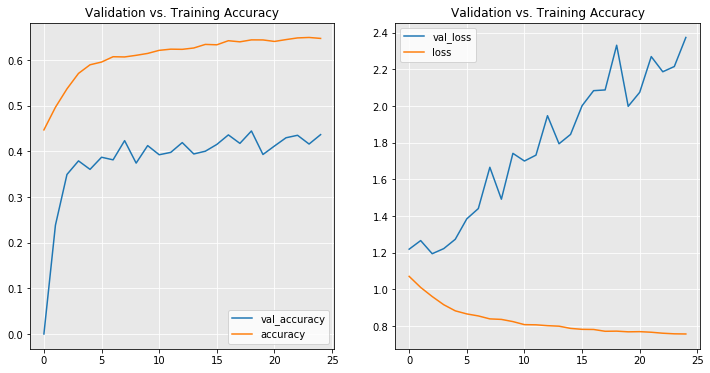

------------------------------------------------------------
Confusion Matrix:
------------------------------------------------------------


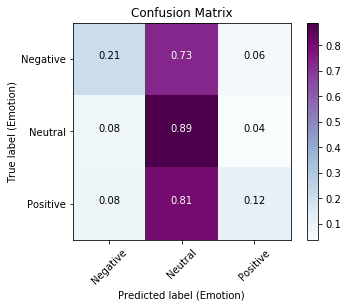

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.16      0.21      0.18       171
           1       0.64      0.89      0.74      1663
           2       0.60      0.12      0.19       894

    accuracy                           0.59      2728
   macro avg       0.46      0.41      0.37      2728
weighted avg       0.59      0.59      0.53      2728



In [145]:
model_w2v_twt = dlf.make_model(cust_emb=wv_t.get_keras_embedding())
dlf.evaluate_model(model_w2v_twt, X_tr_seq_cln_smt, X_te_seq_cln, y_tr_cln_smt, y_te_cln, dlf.Timer, cls_labels=labels, epch=25)

> Once again, my model is overfitting, however with worse performance than that of my model that trained from end-to-end.

## GloVe

> Similar to Word2Vec, GloVe has two different pre-trained embeddings that can be used. One is for general use and the other for Twitter; I will be showing the latter despite testing both initially.

> One must download the embeddings directly from the glove website, then decide which set to import based upon the amount of dimensions in the pre-trained vectors. Due to hardware limitations, it worked quicker and more consistently with 50-dimensions although they offer up to 200-dimensions.

### Importing Vectors

In [146]:
## https://nlp.stanford.edu/projects/glove/
## Need to download separately and put in directory 1st

tot_vocab = tokenizer_2.word_index
glove_twt = {}
with open('glove.twitter.27B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in tot_vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove_twt[word] = vector
f.close()

In [147]:
## Creating 50d matrix to be filled by WVs
emb_matrix_twt = np.zeros((num_words, 50))

## Iteration through tupled information
for word, i in tokenizer_2.word_index.items():
    emb_vector_twt = glove_twt.get(word)

    if emb_vector_twt is not None:
        emb_matrix_twt[i] = emb_vector_twt

### Training

In [149]:
reload(dlf)

<module 'functions' from 'C:\\Users\\d_ful\\Documents\\Personal\\DataSci\\Learn.co\\Curriculum_2.1\\Mod4\\Project4\\functions.py'>

------------------------------------------------------------
Model Summary:
------------------------------------------------------------
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 50)           431600    
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 20)           5680      
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 20)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_17 (Dropout)         (None, 10)         

None

------------------------------------------------------------
Model Training....
------------------------------------------------------------
Train on 8150 samples, validate on 3493 samples
Epoch 1/25
 - 7s - loss: 1.0621 - accuracy: 0.4600 - val_loss: 1.2624 - val_accuracy: 0.0000e+00
Epoch 2/25
 - 6s - loss: 1.0255 - accuracy: 0.4807 - val_loss: 1.2563 - val_accuracy: 0.0057
Epoch 3/25
 - 6s - loss: 0.9830 - accuracy: 0.5155 - val_loss: 1.2190 - val_accuracy: 0.2525
Epoch 4/25
 - 6s - loss: 0.9350 - accuracy: 0.5490 - val_loss: 1.2596 - val_accuracy: 0.3364
Epoch 5/25
 - 6s - loss: 0.9018 - accuracy: 0.5704 - val_loss: 1.2985 - val_accuracy: 0.3212
Epoch 6/25
 - 6s - loss: 0.8712 - accuracy: 0.5890 - val_loss: 1.3784 - val_accuracy: 0.3796
Epoch 7/25
 - 6s - loss: 0.8411 - accuracy: 0.6042 - val_loss: 1.4776 - val_accuracy: 0.4017
Epoch 8/25
 - 6s - loss: 0.8313 - accuracy: 0.6060 - val_loss: 1.5331 - val_accuracy: 0.3810
Epoch 9/25
 - 6s - loss: 0.8204 - accuracy: 0.6076 - val_loss: 

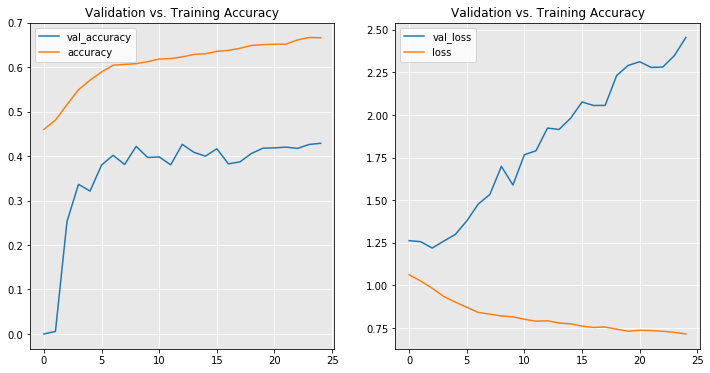

------------------------------------------------------------
Confusion Matrix:
------------------------------------------------------------


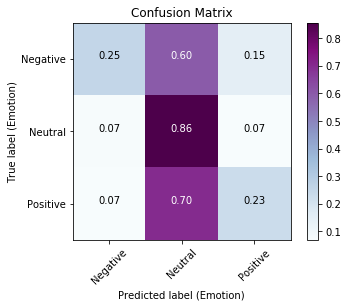

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.19      0.25      0.21       171
           1       0.66      0.86      0.75      1663
           2       0.59      0.23      0.33       894

    accuracy                           0.61      2728
   macro avg       0.48      0.45      0.43      2728
weighted avg       0.61      0.61      0.58      2728



In [150]:
## Presetting embedding layer + training
glve_emb_twt = Embedding(num_words, 50, weights=[emb_matrix_twt], input_length=100, trainable=False)

model_glve_twt = dlf.make_model(cust_emb=glve_emb_twt)
dlf.evaluate_model(model_glve_twt, X_tr_seq_cln_smt, X_te_seq_cln, y_tr_cln_smt, y_te_cln, dlf.Timer, cls_labels=labels, epch=25)

> This seems as-if it will continue to increase in validation accuracy, but the loss graph *clearly* indicates there is overfitting occurring.

# Final Setup

## NN Architecture

> After many iterations I came across this architecture as the *best* model in relation to the baseline's model performance.

In [156]:
reload(dlf)

<module 'functions' from 'C:\\Users\\d_ful\\Documents\\Personal\\DataSci\\Learn.co\\Curriculum_2.1\\Mod4\\Project4\\functions.py'>

In [157]:
## Instantiate
model_fin = Sequential()

## To be added as 'input_dim' for input layer
num_words_fin = X_tr_seq_cln_smt.max() + 1
print('Highest Seq #:')
print(num_words_fin)

## Input layer (input) + dimensions for learning (128)
model_fin.add(Embedding(num_words, embedding_size))

## 1st hidden layer + Pooling to 1d representation + dropout regularization
model_fin.add(LSTM(50, return_sequences=True))
model_fin.add(GlobalMaxPool1D())
model_fin.add(Dropout(0.3))

## 2nd hidden layer + dropout reg.
model_fin.add(Dense(20, activation='relu'))
model_fin.add(Dropout(0.3))

## 3rd hiddenn layer + dropout reg.
model_fin.add(Dense(5, activation='relu'))
model_fin.add(Dropout(0.3))

## Output layer 
model_fin.add(Dense(3, activation='softmax'))

## Compliling model to use Adam / accuracy metric
model_fin.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

## Q.C
model_fin.summary()

Highest Seq #:
8632
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 128)         1104896   
_________________________________________________________________
lstm_14 (LSTM)               (None, None, 50)          35800     
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 50)                0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 20)                1020      
_________________________________________________________________
dropout_28 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_28 (Dense)             (Non

## Training

------------------------------------------------------------
Model Training....
------------------------------------------------------------
Train on 8150 samples, validate on 3493 samples
Epoch 1/25
 - 12s - loss: 1.0809 - accuracy: 0.4533 - val_loss: 1.2474 - val_accuracy: 0.0000e+00
Epoch 2/25
 - 12s - loss: 1.0253 - accuracy: 0.4864 - val_loss: 1.2337 - val_accuracy: 0.3301
Epoch 3/25
 - 11s - loss: 0.8563 - accuracy: 0.5899 - val_loss: 1.3555 - val_accuracy: 0.3977
Epoch 4/25
 - 12s - loss: 0.7551 - accuracy: 0.6216 - val_loss: 1.6264 - val_accuracy: 0.4257
Epoch 5/25
 - 12s - loss: 0.6587 - accuracy: 0.6715 - val_loss: 1.6685 - val_accuracy: 0.4443
Epoch 6/25
 - 12s - loss: 0.5881 - accuracy: 0.7567 - val_loss: 1.8365 - val_accuracy: 0.4520
Epoch 7/25
 - 11s - loss: 0.5181 - accuracy: 0.8054 - val_loss: 2.2007 - val_accuracy: 0.4300
Epoch 8/25
 - 11s - loss: 0.4526 - accuracy: 0.8319 - val_loss: 2.3267 - val_accuracy: 0.4466
Epoch 9/25
 - 11s - loss: 0.4124 - accuracy: 0.8467 - v

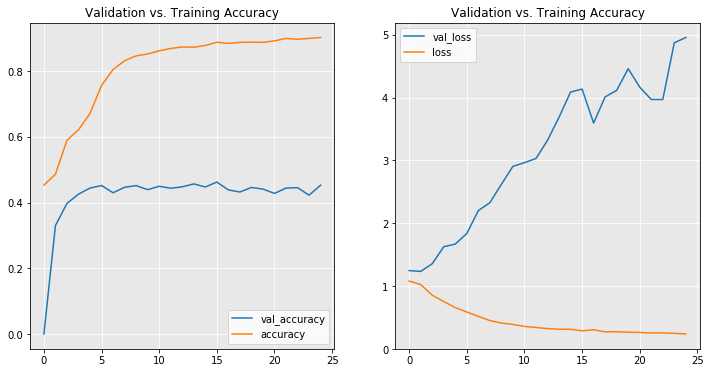

------------------------------------------------------------
Confusion Matrix:
------------------------------------------------------------


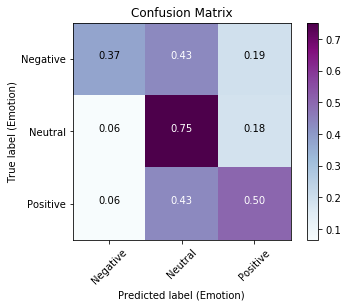

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.28      0.37      0.32       171
           1       0.73      0.75      0.74      1663
           2       0.57      0.50      0.53       894

    accuracy                           0.65      2728
   macro avg       0.53      0.54      0.53      2728
weighted avg       0.65      0.65      0.65      2728



In [154]:
## Training! + eval.
dlf.evaluate_model(model_fin, X_tr_seq_cln_smt, X_te_seq_cln, y_tr_cln_smt, y_te_cln, dlf.Timer, cls_labels=labels, epch=25)

> My final results only improved upon my baseline accuracy by **3%**. Although not much of an increase, given more time and data, this could easily be changed without altering the structure of the network.

# Recommendations & Future Works

## Recommendations

> Given these results this model *as-is* does its best work determining which tweets are either 'Positive' *or* 'Negative'. When the model made its predictions, it was more likely the those predictions were a true 'Negative' or 'Positive' tweet than when it predicted a tweet was 'Neutral'. 
* For any 'Negative' prediction it made on the test data, there was only a 6% chance it was either 'Positive' or 'Neutral' in reality, respectively.
* Similarly, for 'Positive' predictions there was a 18-19% chance it was each of the other classes.

> The most improvement that can be made within my model can be in distinguishing those statements 'in-the-middle'. Based upon the results, it is misclassifying primarily in the 'Neutral' column. This means that some 'Negative' tweets carry some different underlying pattern that my model determines to be more neutral than others. It, as alluded to before, misses 43% of its predictions on true 'Negative' tweets by choosing the 'Neutral' class. This can also be said about true 'Positive' tweets. 
* Otherwise, this model is able to achieve 75% inter-class accuracy within the 'Neutral' class. Meaning it can be effective in weeding out these tweets, but it would be at the expense of losing just under 50% of your non-'Neutral' tweets.

## Future Works

> Given more time I would like to explore a few different avenues.
* More Data!
  * One of the reasons my validation accuracy could be improved is by feeding it more examples to learn from.
* More time with NN architectures
  * I found that many different setups can produce similar results, and with so many knobs to turn, maybe there is something else I missed.
* Standard ML methods
  * Perhaps this problem can adequately be handled by a more traditional ML classifier such as RandomForest or Logistic Regression.